In [1]:
# -------------------------------------------------------------------------------
# Name: main.py
# Purpose: Pull data from twitter, perform sentiment analysis and pull stock data
#
# Author(s):    David Little
#
# Created:      04/26/2021
# Updated:
# Update Comment(s):
#
# TO DO:
#
# -------------------------------------------------------------------------------


import requests
import pandas as pd
import time
import regex as re
from datetime import datetime, timedelta

In [3]:
def get_data(tweet):
    data = {
        'id': tweet['id'],
        'created_at': tweet['created_at'],
        'text': tweet['text'],
        'retweet_count': tweet['public_metrics']['retweet_count'],
        'like_count': tweet['public_metrics']['like_count'],
        'reply_count': tweet['public_metrics']['reply_count']
#        'quote_count': tweet['public_metrics']['quote_count']
    }
    return data

In [4]:
whitespace = re.compile(r"\s+")
web_address = re.compile(r"(?i)http(s):\/\/[a-z0-9.~_\-\/]+")
tesla = re.compile(r"(?i)@Tesla(?=\b)")
user = re.compile(r"(?i)@[a-z0-9_]+")

In [5]:
#------------------------------------- Twitter Pull  --------------------------------------------------------

# setup the API request
endpoint = 'https://api.twitter.com/2/tweets/search/recent'  # 'https://api.twitter.com/2/tweets/search/all'
headers = {'authorization': f'Bearer {BEARER_TOKEN}'}
params = {
    'query': '(tesla OR tsla OR elon musk and -spacex) (lang:en) -is:retweet',
    'max_results': '100',
    'tweet.fields': 'created_at,lang,public_metrics'
        }

In [6]:
dtformat = '%Y-%m-%dT%H:%M:%SZ'  # the date format string required by twitter

# we use this function to subtract 60 mins from our datetime string
def time_travel(now, mins):
    now = datetime.strptime(now, dtformat)
    back_in_time = now - timedelta(minutes=mins)
    return back_in_time.strftime(dtformat)

In [7]:
now = datetime.now()  # get the current datetime, this is our starting point
last_week = now - timedelta(days=6)  # datetime one week ago = the finish line
now = now.strftime(dtformat)  # convert now datetime to format for API
now

'2021-08-27T14:11:06Z'

In [8]:
df = pd.DataFrame()  # initialize dataframe to store tweets
while True:
    if datetime.strptime(now, dtformat) < last_week:
        # if we have reached 6 days ago, break the loop
        break
    pre60 = time_travel(now, 5)  # get x minutes before 'now'
    # assign from and to datetime parameters for the API
    params['start_time'] = pre60
    params['end_time'] = now
    response = requests.get(endpoint,
                            params=params,
                            headers=headers)  # send the request
    time.sleep(2)
    now = pre60  # move the window 60 minutes earlier
    # iteratively append our tweet data to our dataframe
    for tweet in response.json()['data']:
        row = get_data(tweet)  # we defined this function earlier
        if row['like_count']>=1 and row['retweet_count']>=1 and row['reply_count']>=0:   #row['like_count'] >=3:
            df = df.append(row, ignore_index=True)
df

,created_at,id,like_count,reply_count,retweet_count,text
0,2021-08-27T14:10:35.000Z,1431257842598785032,19.0,3.0,1.0,Barry (@ritholtz) posed the question: What was...
1,2021-08-27T14:10:11.000Z,1431257740622635009,2.0,0.0,3.0,WALLSTREETBETS FLASH REPORT : SPRT Short Squee...
2,2021-08-27T14:08:59.000Z,1431257437529640966,188.0,16.0,10.0,THIS DAY IN $TSLAQ HISTORY:\n\nThe profit marg...
3,2021-08-27T14:08:31.000Z,1431257320202268673,6.0,1.0,1.0,I wonder what Tesla would have been like if it...
4,2021-08-27T14:08:14.000Z,1431257249150812161,47.0,1.0,2.0,No $TSLA Golden Cross today unless $TSLA can a...
...,...,...,...,...,...,...
12823,2021-08-21T14:13:03.000Z,1429084135042256900,7.0,1.0,1.0,Just saw a tik tok calling Elon musk ethical a...
12824,2021-08-21T14:11:47.000Z,1429083816098811906,726.0,19.0,70.0,Elon makes you want to live longer and look fo...
12825,2021-08-21T14:11:47.000Z,1429083815532707840,3.0,0.0,3.0,Every now and then I make YouTube videos feel ...
12826,2021-08-21T14:11:30.000Z,1429083743050887171,1.0,0.0,3.0,Lordstown Motors Working On A Military Electri...


In [31]:
#---------------------------------------------- Sentiment Model ------------------------------------------------------

import flair
sentiment_model = flair.models.TextClassifier.load('en-sentiment')

# we will append probability and sentiment preds later
probs = []
sentiments = []
clean_tweets = []
timestamp = []
binary = []

for time in df['created_at']:
    timestamp.append(((datetime.strptime(time, '%Y-%m-%dT%H:%M:%S.%fZ')
                      - timedelta(hours = 4)) #timezone
                      + timedelta(hours = 0) #delay
                     ).strftime('%Y-%m-%d')) # %H:00:00'))

for tweet in df['text']:
# we then use the sub method to replace anything matching
    tweet = whitespace.sub(' ', tweet)
    tweet = web_address.sub('', tweet)
    tweet = tesla.sub('Tesla', tweet)
    tweet = user.sub('', tweet)
    sentence = flair.data.Sentence(tweet)
    sentiment_model.predict(sentence)
    # extract sentiment prediction
    sentiments.append(sentence.labels[0].value)  # 'POSITIVE' or 'NEGATIVE'
    if sentence.labels[0].value == 'NEGATIVE':
        probs.append(-1 * sentence.labels[0].score)  # numerical score 0-1
        binary.append(0)
    else:
        probs.append(sentence.labels[0].score)  # numerical score 0-1
        binary.append(1)
    clean_tweets.append(tweet)
    # print(tweet)
    # print(' ')

# add probability and sentiment predictions to tweets dataframe
df['text_clean'] = clean_tweets
df['probability'] = probs
df['sentiment'] = sentiments
df['binary'] = binary
df['Date'] = timestamp
#df['Date'] = pd.to_datetime(df['Date'])
df

2021-08-27 15:45:40,659 loading file C:\Users\djlittle\.flair\models\sentiment-en-mix-distillbert_4.pt


,created_at,id,like_count,reply_count,retweet_count,text,text_clean,probability,sentiment,binary,Date
0,2021-08-27T14:10:35.000Z,1431257842598785032,19.0,3.0,1.0,Barry (@ritholtz) posed the question: What was...,Barry () posed the question: What was your wor...,-0.999838,NEGATIVE,0,2021-08-27
1,2021-08-27T14:10:11.000Z,1431257740622635009,2.0,0.0,3.0,WALLSTREETBETS FLASH REPORT : SPRT Short Squee...,WALLSTREETBETS FLASH REPORT : SPRT Short Squee...,-0.996346,NEGATIVE,0,2021-08-27
2,2021-08-27T14:08:59.000Z,1431257437529640966,188.0,16.0,10.0,THIS DAY IN $TSLAQ HISTORY:\n\nThe profit marg...,THIS DAY IN $TSLAQ HISTORY: The profit margins...,-0.999844,NEGATIVE,0,2021-08-27
3,2021-08-27T14:08:31.000Z,1431257320202268673,6.0,1.0,1.0,I wonder what Tesla would have been like if it...,I wonder what Tesla would have been like if it...,0.998617,POSITIVE,1,2021-08-27
4,2021-08-27T14:08:14.000Z,1431257249150812161,47.0,1.0,2.0,No $TSLA Golden Cross today unless $TSLA can a...,No $TSLA Golden Cross today unless $TSLA can a...,-0.999223,NEGATIVE,0,2021-08-27
...,...,...,...,...,...,...,...,...,...,...,...
12823,2021-08-21T14:13:03.000Z,1429084135042256900,7.0,1.0,1.0,Just saw a tik tok calling Elon musk ethical a...,Just saw a tik tok calling Elon musk ethical a...,-0.911366,NEGATIVE,0,2021-08-21
12824,2021-08-21T14:11:47.000Z,1429083816098811906,726.0,19.0,70.0,Elon makes you want to live longer and look fo...,Elon makes you want to live longer and look fo...,0.999900,POSITIVE,1,2021-08-21
12825,2021-08-21T14:11:47.000Z,1429083815532707840,3.0,0.0,3.0,Every now and then I make YouTube videos feel ...,Every now and then I make YouTube videos feel ...,0.910736,POSITIVE,1,2021-08-21
12826,2021-08-21T14:11:30.000Z,1429083743050887171,1.0,0.0,3.0,Lordstown Motors Working On A Military Electri...,Lordstown Motors Working On A Military Electri...,0.994145,POSITIVE,1,2021-08-21


In [32]:
#________________________________ Stock Data __________________________________________________________________

import yfinance as yf

#tsla = yf.Ticker("TSLA")
tsla = yf.download( "TSLA",
    start=datetime.strptime(df['created_at'].min(),'%Y-%m-%dT%H:%M:%S.%fZ').strftime('%Y-%m-%d'),
    end=(datetime.strptime(df['created_at'].max(),'%Y-%m-%dT%H:%M:%S.%fZ')+timedelta(days = 2)).strftime('%Y-%m-%d'),
    interval='1d' #'60m'
        )#.reset_index()
tsla_stock = tsla.pct_change().reset_index()

[*********************100%***********************]  1 of 1 completed


In [33]:
converted = []
for time in tsla_stock['Date']:
    converted.append(time.strftime('%Y-%m-%d')) # %H:00:00'))
tsla_stock['Date'] = converted
#tsla_stock['Date'] = pd.to_datetime(tsla_stock['Date'])
tsla_stock

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-08-23,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-08-24,0.036823,0.004339,0.032156,0.003101,0.003101,-0.354396
2,2021-08-25,-0.005136,0.002447,0.001936,0.003825,0.003825,-0.033440
3,2021-08-26,0.001810,-0.002190,-0.009063,-0.014117,-0.014117,0.044972
4,2021-08-27,-0.004673,-0.000573,0.006422,0.015346,0.015346,0.025732


In [34]:
means = df.groupby(['Date'],  as_index=False).mean()
means

,Date,like_count,reply_count,retweet_count,probability,binary
0,2021-08-21,73.156272,6.762439,10.432376,0.015198,0.506657
1,2021-08-22,76.336217,4.702422,11.169550,-0.021718,0.488466
2,2021-08-23,57.846833,4.213820,10.182342,-0.029166,0.486372
3,2021-08-24,52.242169,4.808789,6.247779,0.027900,0.514727
4,2021-08-25,72.891147,5.014030,9.969521,0.023226,0.511369
5,2021-08-26,66.728838,4.616930,10.908178,0.094738,0.548541
6,2021-08-27,36.411765,3.061438,5.406536,0.091686,0.543791


In [35]:
means['Date']

0    2021-08-21
1    2021-08-22
2    2021-08-23
3    2021-08-24
4    2021-08-25
5    2021-08-26
6    2021-08-27
Name: Date, dtype: object

In [36]:
tsla_stock['Date']

0    2021-08-23
1    2021-08-24
2    2021-08-25
3    2021-08-26
4    2021-08-27
Name: Date, dtype: object

In [37]:
combined = means.merge(tsla_stock, how='inner')
combined

,Date,like_count,reply_count,retweet_count,probability,binary,Open,High,Low,Close,Adj Close,Volume
0,2021-08-23,57.846833,4.213820,10.182342,-0.029166,0.486372,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-08-24,52.242169,4.808789,6.247779,0.027900,0.514727,0.036823,0.004339,0.032156,0.003101,0.003101,-0.354396
2,2021-08-25,72.891147,5.014030,9.969521,0.023226,0.511369,-0.005136,0.002447,0.001936,0.003825,0.003825,-0.033440
3,2021-08-26,66.728838,4.616930,10.908178,0.094738,0.548541,0.001810,-0.002190,-0.009063,-0.014117,-0.014117,0.044972
4,2021-08-27,36.411765,3.061438,5.406536,0.091686,0.543791,-0.004673,-0.000573,0.006422,0.015346,0.015346,0.025732


In [38]:
#combined['like_count'].corr(combined['Close'])
combined['binary'].corr(combined['Close'])

-0.2358178344221491

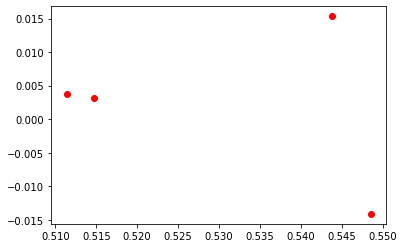

In [39]:
import numpy as np
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1)

# plot the data
ax.plot(combined['binary'],combined['Close'], 'ro')

In [40]:
#import tweepy

#auth = tweepy.OAuthHandler(API_KEY, API_SECRET)
#auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)

#api = tweepy.API(auth)

#public_tweets = api.home_timeline()
#for tweet in public_tweets:
#    print(tweet.text)